In [90]:
#instalamos librerias necesarias
!python -m pip install numpy pandas matplotlib yfinance statsmodels jupyter
#importamos librerias
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import yfinance as yf
import statsmodels.api as sm

#data from sqm and sp500
START = "2014-01-01"
END = "2025-12-31"
TICKER_SQM = "SQM"
TICKER_SP500 = "^GSPC"
TICKER_ETF= "LIT"

#direction of the data of litium insee monthly
LITHIUM_File = "../DATA/Processed data/lithium_insee_real.csv"
LITHIUM_SEP = ";" 




[notice] A new release of pip is available: 25.3 -> 26.0.1
[notice] To update, run: python -m pip install --upgrade pip


In [91]:
tickers = [TICKER_SQM, TICKER_SP500, TICKER_ETF]

#to not have problems with the dividends
prices_daily = yf.download(tickers, start=START, end=END, auto_adjust=True, progress=False)["Close"]

#if series and not dataframe, we convert it to dataframe
if isinstance(prices_daily, pd.Series):
    prices_daily = prices_daily.to_frame()

#to not have problesm with the missing data, we drop the rows with all values missing
prices_daily = prices_daily.dropna(how="all")

#conversion
prices_m = prices_daily.resample("ME").last()

prices_m= prices_m.rename(columns={TICKER_SQM: "SQM", TICKER_SP500: "SP500", TICKER_ETF: "LIT_ETF"})

#returns monthly
returns_m = prices_m.pct_change().dropna()

prices_m.tail(), returns_m.tail()


(Ticker        LIT_ETF        SQM        SP500
 Date                                         
 2025-08-31  47.331474  45.509998  6460.259766
 2025-09-30  56.696045  42.980000  6688.459961
 2025-10-31  62.151234  48.990002  6840.200195
 2025-11-30  63.288143  64.320000  6849.089844
 2025-12-31  65.519997  68.980003  6896.240234,
 Ticker       LIT_ETF       SQM     SP500
 Date                                    
 2025-08-31  0.158126  0.238367  0.019066
 2025-09-30  0.197851 -0.055592  0.035324
 2025-10-31  0.096218  0.139833  0.022687
 2025-11-30  0.018293  0.312921  0.001300
 2025-12-31  0.035265  0.072450  0.006884)

In [92]:
#ordenamos data de litio
from pandas.tseries.offsets import MonthEnd
#definimos variable de lith
lith = pd.read_csv(LITHIUM_File, sep=LITHIUM_SEP)

lith["DATE"] = pd.to_datetime(lith["DATE"], errors="coerce") + MonthEnd(0)
lith["PRICE"] = pd.to_numeric(lith["PRICE"], errors="coerce")

lith = lith.dropna(subset=["DATE","PRICE"]).set_index("DATE").sort_index()

#mensual
lith_m = lith["PRICE"].resample("ME").last().rename("lithium")

df = pd.concat([prices_m, lith_m], axis=1).dropna()
#test
df.tail()



,LIT_ETF,SQM,SP500,lithium
2025-08-31,47.331474,45.509998,6460.259766,81553.9
2025-09-30,56.696045,42.980000,6688.459961,84644.2
2025-10-31,62.151234,48.990002,6840.200195,82990.1
2025-11-30,63.288143,64.320000,6849.089844,85629.7
2025-12-31,65.519997,68.980003,6896.240234,95256.6


In [93]:
#monthly returns
rets = df.pct_change().dropna()
rets.columns
rets.tail()

,LIT_ETF,SQM,SP500,lithium
2025-08-31,0.158126,0.238367,0.019066,0.054404
2025-09-30,0.197851,-0.055592,0.035324,0.037893
2025-10-31,0.096218,0.139833,0.022687,-0.019542
2025-11-30,0.018293,0.312921,0.001300,0.031806
2025-12-31,0.035265,0.072450,0.006884,0.112425


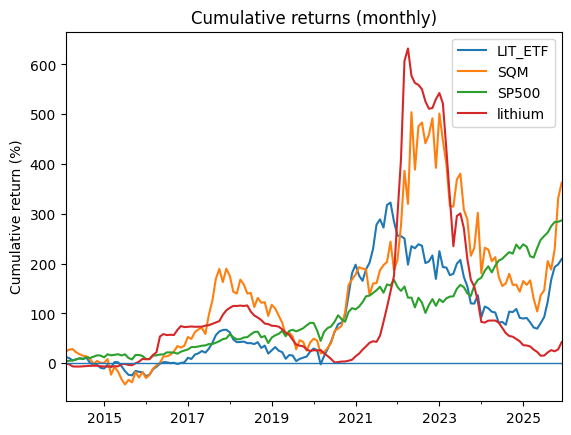

In [94]:
#visual analysis


# returns acumulados en %
cumret = (1 + rets).cumprod() - 1

# plot
ax = (cumret * 100).plot()
plt.title("Cumulative returns (monthly)")
plt.ylabel("Cumulative return (%)")
plt.axhline(0, linewidth=1)
plt.show()

              SQM     SP500   LIT_ETF   lithium
SQM      1.000000  0.344956  0.654828  0.269599
SP500    0.344956  1.000000  0.610804 -0.031985
LIT_ETF  0.654828  0.610804  1.000000  0.084742
lithium  0.269599 -0.031985  0.084742  1.000000


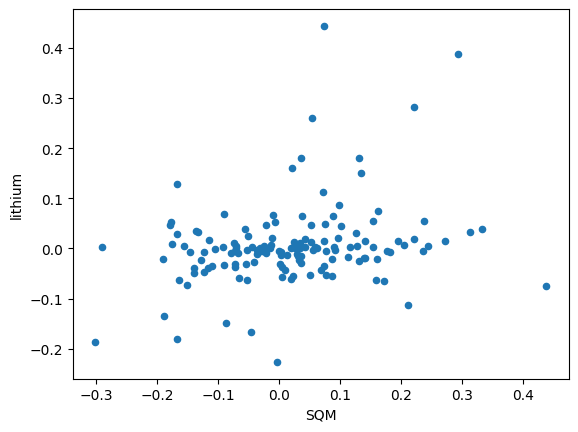

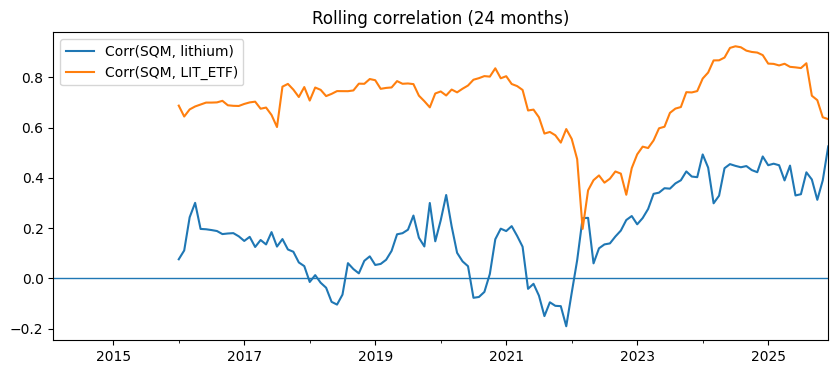

In [95]:
#now we do the correlation analysis
corr = rets[["SQM", "SP500", "LIT_ETF", "lithium"]].corr()

print(corr)

plot = rets[["SQM", "SP500", "LIT_ETF", "lithium"]].plot.scatter(x="SQM", y="lithium")

#what if it is a rolling correlation , so changes with time or smtg???
window = 24
roll_sqm_lith = rets["SQM"].rolling(window).corr(rets["lithium"])
roll_sqm_etf  = rets["SQM"].rolling(window).corr(rets["LIT_ETF"])

plt.figure(figsize=(10,4))
roll_sqm_lith.plot(label="Corr(SQM, lithium)")
roll_sqm_etf.plot(label="Corr(SQM, LIT_ETF)")
plt.axhline(0, linewidth=1)
plt.title(f"Rolling correlation ({window} months)")
plt.legend()
plt.show()

In [96]:
#what if the correlation between lithium and the stock holds with some lag of some months,like a delay os smtg?
rets = df.pct_change().dropna()   
corr_lag2 = rets["SQM"].corr(rets["lithium"].shift(2))
print("Corr(SQM, lithium t-2) =", corr_lag2)

#not very significative, maybe we try the model from chatgpt to choose ourtself ???
best = []
for lag in range(0, 7):
    corr_lag = rets["SQM"].corr(rets["lithium"].shift(lag))
    best.append((lag, corr_lag))

best_df = pd.DataFrame(best, columns=["lag","corr"]).sort_values("corr", ascending=False)
best_df

Corr(SQM, lithium t-2) = 0.12669158249325588


,lag,corr
0,0,0.269599
4,4,0.204998
6,6,0.154847
5,5,0.140249
1,1,0.137594
2,2,0.126692
3,3,0.071393


In [97]:
#all that for nothing lol, maybe a photo for the powerpoint / just mention it
#Beta estimation with model capm (a+Bmkt+e)
RF_ANNUAL = 0.04   # Chilean bonds avg
MRP_ANNUAL = 0.05  #Diff con el avg SP500 (10%) with the chilean bonds

rf_m = (1 + RF_ANNUAL)**(1/12) - 1

ex_sqm = rets["SQM"] - rf_m
ex_mkt = rets["SP500"] - rf_m

X = sm.add_constant(ex_mkt)
capm = sm.OLS(ex_sqm, X).fit(cov_type="HAC", cov_kwds={"maxlags":3})

beta = capm.params["SP500"]
alpha = capm.params["const"]

Ke = RF_ANNUAL + beta * MRP_ANNUAL

print(capm.summary())
print("beta =", beta, "alpha (monthly) =", alpha)
print("Ke (annual) =", Ke)

                            OLS Regression Results                            
Dep. Variable:                    SQM   R-squared:                       0.119
Model:                            OLS   Adj. R-squared:                  0.113
Method:                 Least Squares   F-statistic:                     35.56
Date:                Sat, 21 Feb 2026   Prob (F-statistic):           1.90e-08
Time:                        03:23:33   Log-Likelihood:                 102.94
No. Observations:                 143   AIC:                            -201.9
Df Residuals:                     141   BIC:                            -195.9
Df Model:                           1                                         
Covariance Type:                  HAC                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0078      0.010      0.777      0.4

In [98]:
import numpy as np
import statsmodels.api as sm

# Asegúrate que df tenga columnas: SQM, LIT_ETF, lithium (y quizá SP500)
data = rets[["SQM", "SP500", "LIT_ETF", "lithium"]].replace([np.inf, -np.inf], np.nan).dropna()

y = data["SQM"]
X = sm.add_constant(data[["lithium", "SP500", "LIT_ETF"]])

model = sm.OLS(y, X).fit(cov_type="HAC", cov_kwds={"maxlags":3})

print("R2:", model.rsquared)
print("Adj R2:", model.rsquared_adj)
print(model.summary())
#with the coefficient negative from index , maybe it will be more explicative if we just erase it ??????

R2: 0.4771764368015663
Adj R2: 0.4658924750059166
                            OLS Regression Results                            
Dep. Variable:                    SQM   R-squared:                       0.477
Model:                            OLS   Adj. R-squared:                  0.466
Method:                 Least Squares   F-statistic:                     33.26
Date:                Sat, 21 Feb 2026   Prob (F-statistic):           2.88e-16
Time:                        03:23:33   Log-Likelihood:                 140.25
No. Observations:                 143   AIC:                            -272.5
Df Residuals:                     139   BIC:                            -260.6
Df Model:                           3                                         
Covariance Type:                  HAC                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
co

In [99]:
#test Modelo:lithium + LIT_ETF
data = rets[["SQM", "lithium", "LIT_ETF"]].dropna()

y = data["SQM"]
X_lith_etf = sm.add_constant(data[["lithium", "LIT_ETF"]])

model_lith_etf = sm.OLS(y, X_lith_etf).fit(cov_type="HAC", cov_kwds={"maxlags":3})

print("Modelo: SQM ~ lithium + LIT_ETF")
print("Adj R2:", model_lith_etf.rsquared_adj)
print(model_lith_etf.summary())

Modelo: SQM ~ lithium + LIT_ETF
Adj R2: 0.4674728068854588
                            OLS Regression Results                            
Dep. Variable:                    SQM   R-squared:                       0.475
Model:                            OLS   Adj. R-squared:                  0.467
Method:                 Least Squares   F-statistic:                     50.09
Date:                Sat, 21 Feb 2026   Prob (F-statistic):           3.90e-17
Time:                        03:23:33   Log-Likelihood:                 139.94
No. Observations:                 143   AIC:                            -273.9
Df Residuals:                     140   BIC:                            -265.0
Df Model:                           2                                         
Covariance Type:                  HAC                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------

In [100]:
#test modelo :lithium + SP500
data = rets[["SQM", "lithium", "SP500"]].dropna()

y = data["SQM"]
X_lith_mkt = sm.add_constant(data[["lithium", "SP500"]])

model_lith_mkt = sm.OLS(y, X_lith_mkt).fit(cov_type="HAC", cov_kwds={"maxlags":3})

print("Modelo: SQM ~ lithium + SP500")
print("Adj R2:", model_lith_mkt.rsquared_adj)
print(model_lith_mkt.summary())

Modelo: SQM ~ lithium + SP500
Adj R2: 0.18637036645052385
                            OLS Regression Results                            
Dep. Variable:                    SQM   R-squared:                       0.198
Model:                            OLS   Adj. R-squared:                  0.186
Method:                 Least Squares   F-statistic:                     28.71
Date:                Sat, 21 Feb 2026   Prob (F-statistic):           3.56e-11
Time:                        03:23:33   Log-Likelihood:                 109.64
No. Observations:                 143   AIC:                            -213.3
Df Residuals:                     140   BIC:                            -204.4
Df Model:                           2                                         
Covariance Type:                  HAC                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------

In [101]:
#tables resultats from all models (not significative really :c)
models_table = pd.DataFrame({
    "Modelo": ["lithium + LIT_ETF", "lithium + SP500", "lithium + SP500 + LIT_ETF"],
    "Adj_R2": [model_lith_etf.rsquared_adj, model_lith_mkt.rsquared_adj, model.rsquared_adj],
    "Coef_lithium": [model_lith_etf.params.get("lithium"), model_lith_mkt.params.get("lithium"), model.params.get("lithium")],
    "Pval_lithium": [model_lith_etf.pvalues.get("lithium"), model_lith_mkt.pvalues.get("lithium"), model.pvalues.get("lithium")]
})
models_table

,Modelo,Adj_R2,Coef_lithium,Pval_lithium
0,lithium + LIT_ETF,0.467473,0.328202,8.779935e-04
1,lithium + SP500,0.186370,0.427525,1.701401e-07
2,lithium + SP500 + LIT_ETF,0.465892,0.320548,1.338580e-03


In [102]:
import statsmodels.api as sm


data = rets[["SQM", "SP500", "LIT_ETF", "lithium"]].dropna()

# Purify LIT_ETF: sacar componente explicado por SP500
X_mkt = sm.add_constant(data["SP500"])
etf_on_mkt = sm.OLS(data["LIT_ETF"], X_mkt).fit()

data["LIT_sector"] = etf_on_mkt.resid  #pure sector

# Modelo final 
X = sm.add_constant(data[["SP500", "LIT_sector", "lithium"]])
model_sector = sm.OLS(data["SQM"], X).fit(cov_type="HAC", cov_kwds={"maxlags":3})

print("Modelo: SQM ~ SP500 + LIT_sector + lithium")
print("Adj R2:", model_sector.rsquared_adj)
print(model_sector.summary())

Modelo: SQM ~ SP500 + LIT_sector + lithium
Adj R2: 0.4658924750059168
                            OLS Regression Results                            
Dep. Variable:                    SQM   R-squared:                       0.477
Model:                            OLS   Adj. R-squared:                  0.466
Method:                 Least Squares   F-statistic:                     33.26
Date:                Sat, 21 Feb 2026   Prob (F-statistic):           2.88e-16
Time:                        03:23:33   Log-Likelihood:                 140.25
No. Observations:                 143   AIC:                            -272.5
Df Residuals:                     139   BIC:                            -260.6
Df Model:                           3                                         
Covariance Type:                  HAC                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------

In [103]:
#the model explain only half but its okay , chilean macro + currency problems ?
#Traditional approach with Gordon (Dividend Discount)
sqm_ticker = yf.Ticker(TICKER_SQM)
div = sqm_ticker.dividends.copy()

# deja todo tz-naive
div.index = div.index.tz_localize(None)

# cutoff = última fecha de tu df (tz-naive )
cutoff = pd.Timestamp(df.index[-1]).to_pydatetime().replace(tzinfo=None)

# filtrar dividendos hasta esa fecha
div = div[div.index <= cutoff]

# dividendos últimos 12 meses
D0 = div[div.index >= (div.index.max() - pd.DateOffset(years=1))].sum()

g = 0.025 #chilean CAGR PBI AVG
D1 = D0 * (1 + g)

P_gordon = D1 / (Ke - g)
P_gordon

np.float64(81.72358450683043)

In [104]:
import numpy as np


# now multiples with EV/Sales and peers comp (EPS negativo in industry)
#if not we calculate it ourselfs
def get_ev(info):
    ev = info.get("enterpriseValue")
    if ev is None or not np.isfinite(ev):
        mcap = info.get("marketCap") or 0
        debt = info.get("totalDebt") or 0
        cash = info.get("totalCash") or 0
        ev = mcap + debt - cash
    return ev

info_sqm = yf.Ticker(TICKER_SQM).info

# peers all in USD 
peers = ["ALB", "LAC", "PILBF", "	GNENF"]
peer_mult = []

for p in peers:
    info_p = yf.Ticker(p).info
    ev_p = get_ev(info_p)
    rev_p = info_p.get("totalRevenue")

    if rev_p is not None and np.isfinite(rev_p) and rev_p > 0 and np.isfinite(ev_p):
        peer_mult.append(ev_p / rev_p)

peer_median_mult = np.median(peer_mult)

# aplicar a SQM
ev_sqm = get_ev(info_sqm)
rev_sqm = info_sqm.get("totalRevenue")

EV_implied = peer_median_mult * rev_sqm

shares = info_sqm.get("sharesOutstanding")
debt = info_sqm.get("totalDebt") or 0
cash = info_sqm.get("totalCash") or 0
net_debt = debt - cash

equity_value = EV_implied - net_debt
P_multiple = equity_value / shares

P_multiple

np.float64(125.1832645229658)

In [105]:
#now we do dcf also
import numpy as np

# INPUTS from  factset
FCFF0 = 944_690_000  # i took 2025 Estimate , because the 2024 is not representative and we dont have the real yet in factset.
WACC = 0.059            # factset
g_fcff = 0.02          # g FCFF factset avg
gT = 0.02              # g terminal
N = 5

fcff = np.array([FCFF0 * (1 + g_fcff)**t for t in range(1, N+1)])
disc = np.array([(1 + WACC)**t for t in range(1, N+1)])
pv_fcff = (fcff / disc).sum()

TV = (fcff[-1] * (1 + gT)) / (WACC - gT)
pv_tv = TV / ((1 + WACC)**N)

EV = pv_fcff + pv_tv

info = yf.Ticker(TICKER_SQM).info
shares = info.get("sharesOutstanding")
debt = info.get("totalDebt") or 0
cash = info.get("totalCash") or 0

net_debt = debt - cash
equity_value = EV - net_debt
P_dcf = equity_value / shares

P_dcf

np.float64(156.6179428115268)

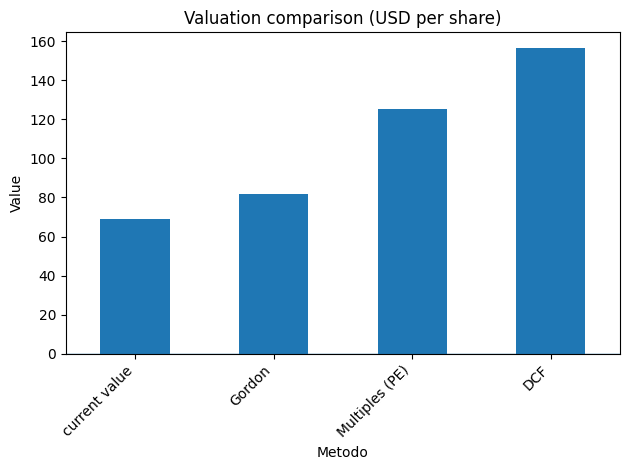

In [106]:
#table with results
P_market = df["SQM"].iloc[-1]

valuation_table = pd.DataFrame({
    "Metodo": ["current value", "Gordon", "Multiples (PE)", "DCF",],
    "Valor":  [P_market, P_gordon, P_multiple, P_dcf,]
})

valuation_table

#graph for the powerpoint
ax = valuation_table.set_index("Metodo")["Valor"].plot(kind="bar")
plt.title("Valuation comparison (USD per share)")
plt.ylabel("Value")
plt.xticks(rotation=45, ha="right")
plt.axhline(0, linewidth=1)
plt.tight_layout()
plt.show()

we explain this diff by the high ev/sales multiple aswell as the low wacc that factset gives us, all other numbers took are conservative.


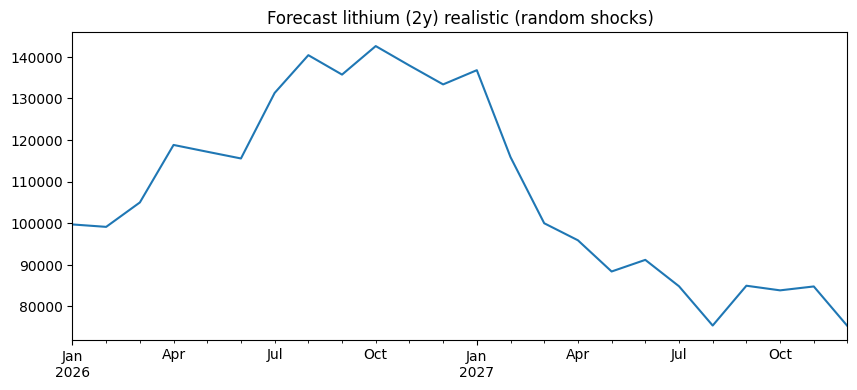

In [107]:
#parametros del forecats of lithium
np.random.seed(42)
h = 24
future_index = pd.date_range(df.index[-1] + pd.offsets.MonthEnd(1), periods=h, freq="ME")

mu_lith = rets["lithium"].mean()
sd_lith = rets["lithium"].std()

# retornos futuros con ruido
lith_rets_fc = pd.Series(np.random.normal(mu_lith, sd_lith, h), index=future_index)

# precios futuros
lith0 = df["lithium"].iloc[-1]
lith_price_fc = lith0 * (1 + lith_rets_fc).cumprod()

lith_price_fc.plot(title="Forecast lithium (2y) realistic (random shocks)", figsize=(10,4))
plt.show()

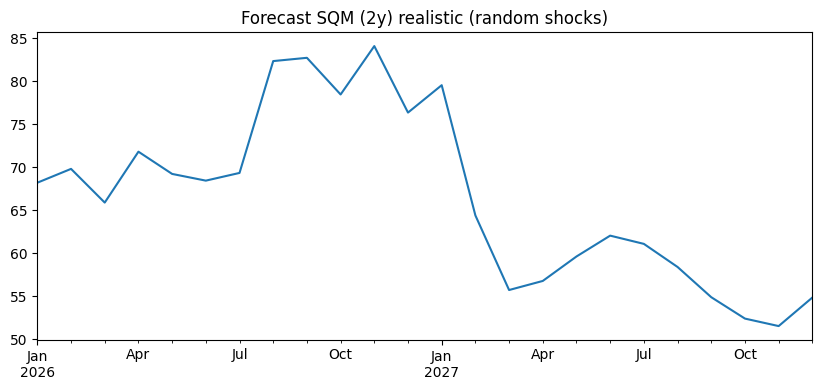

In [108]:
#now  forecats of the model with 2 variables (higher R2) , the one with the ETF+ commodity lithium

np.random.seed(42)
h = 24
future_index = pd.date_range(df.index[-1] + pd.offsets.MonthEnd(1), periods=h, freq="ME")

# medias y volatilidades históricas
mu_lith = rets["lithium"].mean()
sd_lith = rets["lithium"].std()

mu_etf = rets["LIT_ETF"].mean()
sd_etf = rets["LIT_ETF"].std()

# generar retornos futuros con variación
lith_fc = pd.Series(np.random.normal(mu_lith, sd_lith, h), index=future_index)
etf_fc  = pd.Series(np.random.normal(mu_etf,  sd_etf,  h), index=future_index)

# predicción retornos SQM
X_future = pd.DataFrame({"lithium": lith_fc, "LIT_ETF": etf_fc}, index=future_index)
X_future = sm.add_constant(X_future, has_constant="add")
X_future = X_future[model_lith_etf.model.exog_names]

sqm_rets_fc = model_lith_etf.predict(X_future)

# pasar a precios
P0 = df["SQM"].iloc[-1]
sqm_price_fc = P0 * (1 + sqm_rets_fc).cumprod()

sqm_price_fc.plot(title="Forecast SQM (2y) realistic (random shocks)", figsize=(10,4))
plt.show()